# What are the common activities that the victims were engaged in prior to the accident?

In [525]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 23 15:12:27 2017

@author: leeto
"""
import os
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.util import ngrams
from nltk.tag.util import *
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# List Of Category indexes as per stated in the CA document

In [526]:
CategoryIndexes = {"Caught in/between Objects":0,
                     "Falls":1,
                     "Drowning":2,
                     "Other":3,
                     "Others":3,
                     "Struck By Moving Objects":4,
                     "Collapse of object":5,
                     "Fires and Explosion":6,
                     "Electrocution":7,
                     "Suffocation":8,
                     "Exposure to Chemical Substances":9,
                     "Exposure to extreme temperatures":10,
                     }
CategoryNames = {0:"Caught in/between Objects",
                     1:"Falls",
                     2:"Drowning",
                     3:"Other",
                     4:"Struck By Moving Objects",
                     5:"Collapse of object",
                     6:"Fires and Explosion",
                     7:"Electrocution",
                     8:"Suffocation",
                     9:"Exposure to Chemical Substances",
                     10:"Exposure to extreme temperatures",
                     }

# Classes to store the category and case items together with helper functions

In [527]:
def GetCategoryIndex(Name):
    if Name in CategoryIndexes:
        return CategoryIndexes[Name]
    else:
        return -1
    
def GetCategoryName(Index):
    if (Index in CategoryNames):
        return CategoryNames[Index]
    else:
        return "Invalid Category"
        
#Classes To Be Used 
class Category(object):
    def __init__(self, Name, Index):
        self.Name = Name
        self.Index = Index
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []
        
    def __str__(self):
        return("Category Item:\n"
               "  Name = {0}({1})\n"
               "  ActivityVerb = {2}\n"
               "  ActivityChunk = {3}\n"
               .format(self.Name, self.Index, str(len(self.ActivityTokensVerb)) , str(len(self.ActivityTokensChunk))))
        
class CaseItem(object):
    def __init__(self, Title, Summary, CauseName, CauseIndex):
        self.CauseName = CauseName
        self.CauseIndex = CauseIndex
        self.Title = Title
        self.Summary = Summary
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []

    def __str__(self):
        return("Case Item:\n"
               "  Cause = {0}({1})\n"
               "  Title = {2}\n"
               "  Summary = {3}\n"
               .format(self.CauseName, self.CauseIndex, self.Title, self.Summary))

# Read from excel, populate case items, intialization of categories

In [528]:
#read from excel, populate case items
def ReadFromExcelAndPopulateCase():
    global MsiaCaseItems 
    global OshaCaseItems
    MsiaCaseItems = []
    OshaCaseItems = []
    MsiaCasesDF=pd.read_excel(MsiaCasesFile,sheetname=0)
    OshaDF=pd.read_excel(OshaCasesFile,sheetname=0)
    MsiaCasesDF.groupby('Cause ').describe()
    # For each row in the column,
    for index,row in MsiaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], row['Cause '], GetCategoryIndex(row['Cause ']))
        MsiaCaseItems.append(TempCaseItem)
    # For each row in the column,
    for index,row in OshaDF.iterrows():
        TempCaseItem = CaseItem(row['Title'], row['Summary'], row['Cause'], GetCategoryIndex(row['Cause']))
        OshaCaseItems.append(TempCaseItem)

#Initialize Categories array
def InitializeCategories():
    global MsiaCategories
    global OshaCategories
    MsiaCategories = []
    OshaCategories = []
    for index in CategoryNames:
        tempcat = Category(GetCategoryName(index),index)
        MsiaCategories.append(tempcat)
        OshaCategories.append(tempcat)
        
def write_to_file(filename, text):
    f = open(filename, 'a')
    f.write(text + '\n')  # python will convert \n to os.linesep
    f.close()  # you can omit in most cases as the destructor will call it

# Visualisation function to plot frequency distribution, word cloud and list some of the common activities

In [529]:
# Visualisation function to plot frequency distribution, word cloud and list some of the common activities
def Visualisation(category):   
    #tokens = word_tokenize(text)
    if (len(category.ActivityTokensVerb)>0):
        # frequecy distribution chart
        print(category.Name)
        #tokens_clean = [ t for t in category.ActivityTokensVerb if len(t) >= 3 ]
        tokens_clean_single = []
        for tok1 in category.ActivityTokensVerb:
            for tok2 in tok1:
                tokens_clean_single.append(tok2)
        fd = nltk.FreqDist(tokens_clean_single)
        fd.most_common(25)
        TopActivityTokens = fd.most_common(3)
        fd.plot(25)
        #print(tokens_clean_single)
        #print(TopActivityTokens)
        
        # ==== Installation of wordcloud package
        # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
        # 2. Copy the file to your current working directory
        # 3. Open command prompt from Tools
        # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl
    
        # 1. Simple cloud
        # Generate a word cloud image
        # Take note that this function requires text string as input
        # text = "".join([' '+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
        text = ' '.join(tokens_clean_single)
        wc = WordCloud(background_color="white").generate(text)
        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()    
        
        chunks_limit = 10
        print("Top 3 activity word and their sentences")
        print("=======================================\n")
        for word in TopActivityTokens:
            chunks_count = 0
            underline = ""
            print('\n' + word[0])
            for c in word[0]:
                underline += '='
            print(underline + '\n')
            #Populate sentences belonging to top tokens
            for chunk1 in category.ActivityTokensChunk:
                for chunk2 in chunk1:
                    chunk_token = nltk.sent_tokenize(chunk2)
                    chunk_lemma_token = get_lemma(chunk_token)
                    #print(chunk_lemma_token)
                    #chunk_text = ' '.join(chunk)
                    if len(chunk_lemma_token) >= 1:
                        #print (chunk_lemma_token)
                        for token in chunk_lemma_token:
                            if word[0] in get_lemma_word(token.split(' ')[0]):
                                if (chunks_count < 10):
                                    print(chunk2)
                                chunks_count += 1

            print("\n")
    else:
        print("Visualisation Function : NO DATA AVAILABLE")



# Text Mining helper functions 
- get_lemma - lemmatizer to get the base word based on speech tag
- get_stem - similar to get_lemma but some of the base words are not correct, so I did not use this
- get_verb_count - returns number of verb word found in the sentence
- filter_off_unwanted chunks - custom filter to more accurately extract verb associated with the activities

In [530]:
def get_lemma(subtree):        
    return [ WNlemma.lemmatize(t, 'v') for t in subtree ]

def get_lemma_word(text):
    return WNlemma.lemmatize(text, 'v')

def get_stem(subtree):
    return [ Stemmer.stem(t) for t in subtree ]

def get_verb_count(subtree):
    verb_count = 0
    tokens = nltk.pos_tag(word_tokenize(str(subtree))) 
    for tok in tokens:
        if ('\'VBG\'' in str(tok)) or ('\'VB\'' in str(tok)):
            verb_count += 1
    return verb_count

def filter_off_unwanted_chunks(subtree):
    # first words : crashing, causing, involving, doing, being, falling
    filter_first_words = ['crash', 'cause', 'involve', 'do', 'be', 'fall', 'avoid', 'result', 'address', 'have']
    filter_all_words = ['kill', 'carry out work']
    filter_last_words = ['victim', 'work']
    filter_short_words = ['carry', 'perform']   
    for ffw in filter_first_words:
        if (ffw in get_lemma(untag(subtree))[0]):
            return False, subtree
    for flw in filter_last_words:
        if (flw in get_lemma(untag(subtree))[len(subtree)-1]):
            return False, subtree
    for fsw in filter_short_words:
        if ( fsw in str(' '.join(get_lemma(untag(subtree)))) and (len(subtree)<=2) ):
            return False,subtree
    for faw in filter_all_words:
        if ( faw in str(' '.join(get_lemma(untag(subtree)))) ):
            return False, subtree
    if get_verb_count(untag(subtree)) > 0:  
        return True, subtree
    else: 
        return False, subtree

def clean_up_chunk(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    return text

def clean_up_verb(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    text = text.replace(' ','')
    return text

# Main function to extract the activities sentences and verb
- 1st loop (ie. OCC1) is used for extracting the sentences containing the activities. The RegexpParser will look for verb in past tenses(VBD), base form(VB), past participle(VBN), present participle(VBG) etc that is constructed together with nouns(singular, plural, proper noun,) as well as preposition(IN), adjective(JJ), particle(PR).

- 2nd loop (ie. OCC2) is used to further extract the base verb that is found using OCC1.

In [531]:
def extract_activities_chunk_and_verb(text):
    chunk_grammar = r"""
        OCC1:{<VBG|VB>+<IN|DT|JJ|RP>*<NN|NN.*>+(<IN|DT|JJ|RP>*<VBG|VB>+<NN|NN.*>+)?}
    """
    verb_grammar = r"""
        OCC2:{<VBG|VB>+}
    """    
#   original OCC:{<VBG|VB>+<IN|DT|JJ|RP>?<NN|NN.*>+<VBG|VB>?}
    ExtractedActivitiesChunk = []
    ExtractedActivitiesVerb = []
    if (not text=="") and (len(text) >= 3):
        chunk_parser = nltk.RegexpParser(chunk_grammar)
        tokens_chunk = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        tagged_chunk = nltk.pos_tag(tokens_chunk)
        if (len(tagged_chunk) > 0):
            extract_chunk = chunk_parser.parse(tagged_chunk)
            for subtree_chunk in extract_chunk.subtrees(filter=lambda t: 'OCC1' in t.label()):  
                acceptChunk, processed_subtree_chunk = filter_off_unwanted_chunks(subtree_chunk)
                if (acceptChunk == True):
                    token_chunk_clean = untag(processed_subtree_chunk)
                    #token_chunk_clean_str = clean_up_chunk(str(get_lemma(token_chunk_clean)))
                    token_chunk_clean_str = clean_up_chunk(str(token_chunk_clean))
                    print(token_chunk_clean_str + "(" + str(get_verb_count(untag(processed_subtree_chunk))) + ")")
                    ExtractedActivitiesChunk.append(token_chunk_clean_str)
                    verb_parser = nltk.RegexpParser(verb_grammar)
                    tokens_verb = [word for sent in nltk.sent_tokenize(token_chunk_clean_str) for word in nltk.word_tokenize(sent)]
                    tagged_verb = nltk.pos_tag(tokens_verb)
                    if (len(tagged_verb) > 0):
                        extract_verbs = verb_parser.parse(tagged_verb)
                        for subtree_verb in extract_verbs.subtrees(filter=lambda t: 'OCC2' in t.label()):  
                            #print(subtree_verb)
                            tokens_verb_lem = get_lemma(untag(subtree_verb))   
                            tokens_verb_lem_clean = clean_up_verb(str(tokens_verb_lem))
                            #print(tokens_verb_lem_clean)
                            ExtractedActivitiesVerb.append(clean_up_verb(str(tokens_verb_lem_clean)))
    return ExtractedActivitiesChunk, ExtractedActivitiesVerb

# Main Loop
- Initializes the case and categories item
- create the lemmatizer and stemmer objects
- read from excel and populate the case and categories

In [532]:
# Initialize     
MsiaCategories = []
MsiaCaseItems = []
OshaCategories = []
OshaCaseItems = []
MsiaCasesFile = 'MsiaAccidentCases.xlsx'
#the Osha case file must have the causes populated by the predictor model developed by Vincent
OshaCasesFile = 'osha1.xlsx'

#NLTK Objects
# lemmatize to convert to base words depending on speech tagging
WNlemma = nltk.WordNetLemmatizer()
# stemmer to get the base words
Stemmer = nltk.SnowballStemmer('english')   

#Initilize categories
InitializeCategories()
#Read data from excel and populate case items
ReadFromExcelAndPopulateCase()

# Flags to determine which data set to use. 
- ProcessMsiaDataSet for Msia Dataset
- ProcessOshaDataSet for Osha Dataset

In [533]:
# if False, means process the Osha dataset
ProcessMsiaDataSet = False
ProcessOshaDataSet = True

# Main Processing Section 1
- Loops through each case item then populate the activities sentences and verb token 

In [534]:
if ProcessMsiaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in MsiaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in MsiaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

In [535]:
if ProcessOshaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in OshaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in OshaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

installing ladder scaffold structure(1)
clothing point(1)
paving equipment operator(1)
earthmoving equip bulldozer maintenance(1)
installing arm fracture face abrasion(1)
handling ind trk operator(1)
loading ramp loading dock(2)
walking surface fall contusion abrasion(1)
grinding machine(1)
grinding machine(1)
sandblasting abrasive blasting(2)
rotating parts hand(1)
sandblasting abrasive blasting(2)
sandblasting face neck concussion(1)
sandblasting respirator(1)
grinding wheel(1)
sharpening machine glove thumb laceration rotating parts(2)
cleaning chemical burn ppe jet fuel hand(1)
hoisting mechanism(1)
loading machinist abrasive wheel(1)
handling rotating parts(2)
rotating parts work rules(1)
cleaning refinery(1)
packing hand conveyor belt roller(1)
cleaning conveyor(1)
clothing forearm(1)
rotating shaft(1)
clothing fracture rib work rules(1)
flying object abrasive wheel laceration fracture leg(1)
flying object fracture grinder(1)
flying object eye ppe(1)
rotating parts(1)
grinding ma

poisoning animal bite leg(1)
poisoning security guard(1)
cleaning tendon laceration puncture(1)
ring caught(1)
installing electronic equipment ladder electric(1)
loading dock overturn(1)
trimming fall ppe(1)
installing mobile home hydraulic jack slip(1)
moving equip tractor run(1)
rigging backing up fall(2)
decking antenna(1)
rigging antenna equipment failure rope communication tower(1)
welding electric arc arc welding maintenance fire burn ppe cutting(3)
burning earthmoving equip(2)
welding welding oil drum explosion burn(2)
welding lubricating fluid oil tank explosion gas gas(2)
welding burn arm lubricating fluid pipeline(2)
welding fire burn(1)
welding welding pipe explosion(2)
welding burn ppe clothing arc(2)
welding contusion abrasion(1)
welding burn ppe spark construction(1)
welding welding welder(2)
welding cable welding installing(3)
burning naphtha fire(1)
welding arc welding truck construction(2)
welding head(1)
welding vapor support posts(1)
welding repair slip(1)
welding pp

installing table saw hand(1)
grinding machine point(1)
rotating knife blade finger(1)
slicing machine(1)
melting furnace(1)
pouring gas burn(1)
flying object blast furnace collapse(1)
dismantling blast furnace(1)
purging work rules(1)
cleaning work rules(1)
blasting blast furnace(1)
blasting tank cleaning laceration foot(2)
blasting paint fall(1)
blasting ppe(1)
blasting explosion explosives gas(1)
blasting pot(1)
blasting electrical work rules(1)
plumbing poisoning bleach(2)
installing stomach loss(1)
handling chemical burn(1)
cleaning bleach chemical reaction(1)
handling falling object bleach chemical burn leg(2)
deboning vapor(1)
printing printing press machine operator lockout(2)
reaching caught(1)
reaching nip point(1)
reaching struck(1)
printing press drain pipe blind reaching printing machine operator finger(3)
reaching blade finger(1)
reaching concrete mixer(1)
reaching falling object work rules(2)
reaching work rules(1)
descending fall(1)
reaching hand wrist laceration fractur

dismantling work rules(1)
installing manual mat handling arm(2)
cleaning extension ladder ladder fall fall protection(1)
welding broken weld(1)
landing stair(1)
walking on beam iron worker contusion(1)
installing fall fracture head(1)
welding broken weld fall protection(1)
cleaning fall grader broom(1)
cleaning trailer slope slip fall hip(1)
cleaning brush chipper milling machine guard(2)
flying object head(1)
flying object(1)
flying object tree limb chipper brush chipper head heart attack(1)
trimming tree brush chipper(1)
felling head neck clearance(1)
felling head brush chipper chain(1)
dismantling equipment failure(1)
felling tree boom(1)
felling bucking slip slippery surface fall tibia(2)
felling fall(1)
bucking tree unstable load(1)
bucking tree log(1)
logging bucking saw chain chain(2)
bucking hand tool caught(1)
logging horse blade bucking(2)
bucking log face chain(1)
bucking slope log(1)
logging tree chock slope(1)
bucking chest(1)
logging work rules(1)
building repair installi

handling chair sprain(1)
sling steel beam charge bucket chest(1)
hoisting mechanism maintenance(1)
piping burn check valve(1)
flying object fall(1)
flying object equipment failure(1)
flying object pressure release check valve mech malfunction(1)
mixing pump hose ppe(1)
poisoning lung explosion(1)
cleaning chemical burn foot ankle(1)
cleaning disinfectant chemical burn arm(1)
poisoning chemical vapor(1)
cleaning burn water food preparation chemical burn(1)
burn chemical burn pressure piping pressure release(1)
cleaning tank tank cleaning sodium(2)
piping burn chemical reaction(1)
cleaning tank paint(1)
poisoning chemical vapor inhalation(1)
cleaning chemical vessel(1)
cleaning burn fire head mixer tank(1)
lighting burn(1)
flying object chest(1)
rotating parts(1)
shearing machine tank chlorine gas poisoning inhalation chest dizziness(2)
installing sheet metal fall fall protection(1)
descending chimney fracture rib lung(1)
walking surface construction(1)
handling leg(1)
cleaning fall prot

plumbing head concussion(1)
flying object unsecured work rules(1)
cleaning lockout(1)
pouring boom(1)
installing steel stepladder ladder fall fall protection concrete slab pelvis fracture(1)
decking fall fall protection hip fracture concrete slab(1)
grinding wheel laceration hand wrist(1)
backing up concrete slab puncture construction(1)
loading ramp overturn fracture neck(1)
walking surface slippery surface(1)
cleaning nip point(1)
rotating parts(1)
handling laceration head(1)
loading ramp(1)
loading flatbed truck truck pallet slip fall fracture concussion(1)
welding electrode conductive apparel e gi iii(1)
servicing heat arm leg(1)
installing conduit(1)
plumbing conduit gas arm(1)
rotating parts machine(1)
disconnecting means(1)
dismantling fall fall protection fracture leg arm(1)
molding machine(1)
opening fall(1)
rotating parts repair(1)
installing manhole manhole cover(1)
flying object(1)
installing slippery surface fall fall protection fracture decking work surface(2)
grating fal

felling tree section logger(1)
installing metal(1)
decking potential gradient fall(1)
installing decking fall roof puncture lung(2)
decking installing fall protection fall(2)
decking installing rail(2)
decking roof fall fracture head shoulder(1)
decking traffic control motor vehicle(1)
decking unsecured wrist pelvis(1)
installing fire ext system stepladder decking fall fall protection leg fracture(2)
installing wall scaffold(1)
decking head arm(1)
decking fall fall protection(1)
installing unstable surface fracture(1)
decking construction(1)
decking panel(1)
opening building decking panel(3)
decking decking panel(2)
decking panel lumber(1)
decking panel(1)
decking panel crane foot(1)
decking decking panel fall(2)
decking decking panel fracture(2)
decking decking panel repair fall(2)
decking panel(1)
opening fall tie-off work rules(1)
decking decking panel steel beam(2)
decking panel work surface(1)
decking panel(1)
decking panel puncture leg(1)
decking panel tibia equipment failure(1)


drilling counterbalance drill(1)
drilling valve pressure release equipment failure(1)
flying object leg fracture work rules(1)
travelling block(1)
drilling machine(1)
drilling machine(1)
rotating parts drill operator(1)
drilling machine metal(1)
handling equipment operator(1)
flying object(1)
drill pipe rotating parts(1)
flying object(1)
riding on equipment pipe head concussion(1)
handling work rules(1)
rotating parts(1)
drilling machine(1)
milling machine(1)
rotating parts(1)
rotating parts(1)
rotating parts(1)
rotating shaft(1)
drill press rotating parts(1)
drilling oil rig drill rig(1)
rotating parts(1)
backing up truck driver wheel asphalt drill rig(1)
plumbing drilling machine pipe(2)
rotating parts(1)
drilling machine glove(1)
rotating parts work rules(1)
rotating parts work rules drilling machine(2)
rotating parts cleaning glove(2)
rotating parts(1)
drilling mud(1)
drilling mud construction leg work surface(1)
drilling mud struck(1)
drilling mud laceration leg fracture skull(1)


installing scaffold guardrail electric shock(1)
lighting fixture(1)
lighting fixture(1)
lighting circuit repair hand work rules(1)
lighting circuit(1)
grounding electric sign cord(1)
grounding electric sign(1)
testing burn head arm hand transformer(1)
testing electric switch(1)
lighting lighting fixture fall(2)
lighting fixture ladder fall fall protection fracture foot(1)
washing machine(1)
shoring fall electrical box fracture work surface(1)
lighting circuit(1)
printing press(1)
bracing guard(1)
installing fire burn arm electric cable(1)
installing lighting electrical splice(2)
testing electrician transformer test equipment burn(1)
lubricating fluid fire explosion face hand(1)
testing transformer test equipment burn(1)
lubricating fluid fire explosion face(1)
testing electric shock(1)
opening electrical testing(2)
testing electrical fault burn(1)
testing electrical fault(1)
testing electric shock(1)
opening burn(1)
installing lighting lighting fixture ladder(3)
casting machine(1)
inst

cleaning slippery surface caught(1)
rotating knife rotating parts(2)
lighting lighting fixture(2)
binding machin(1)
installing pipe(1)
cleaning foot control(1)
backing up trailer caught(1)
rotating parts hand laceration(1)
lubricating fluid(1)
housekeeping fracture(1)
handling power press machine operator guard(1)
drawing machine(1)
molding machine plastic mfg power press(1)
cutting press(1)
retaining wall(1)
installing water pipe abrasion contusion(1)
blending mach lockout(1)
cleaning roof extension ladder ladder fall(1)
flying object inadequate maint laceration forehead(1)
housekeeping vapor(1)
forming machine overturn(1)
forming machine(1)
forming machine fracture arm pressure release(1)
forming machine(1)
forming machine heat(1)
forming machine laceration arm(1)
forming machine hand(1)
molding machine forming machine hand finger(2)
packing house food packaging mach mech malfunction(2)
forming machine(1)
forming machine caught(1)
forming machine concrete cleaning hand fracture(2)
fo

handling handrail(1)
cleaning stair(1)
walking surface handrail(1)
scaffolding fall fall protection handrail(1)
scaffolding head fracture(1)
clothing caught(1)
felling hard hat concussion head(1)
rotating knife foot laceration fracture(1)
installing cover(1)
rotating parts(1)
installing roof ladder hatch(1)
opening hatch fall fracture leg carpenter(1)
warning sign work rules construction(1)
longshoring barge ship hatch winch equipment operator head concussion(1)
logging log haulback line(1)
logging work rules(1)
yarding mech mat handling(2)
flying object(1)
logging fracture(1)
logging rigging communication(2)
yarding haulback line choker(1)
logging haulback line loss(1)
logging haulback line work rules(1)
cleaning hazardous waste chemical(1)
handling ppe(1)
loading mech mat handling(2)
opening hip leg head(1)
binding machin struck(1)
hoisting mechanism rigging head mech malfunction(2)
hoisting mechanism transmission tower headache ball(1)
flying object(1)
10655184910/25/19951796King La

poisoning chemical vapor overexposure chemical vapor ventilation respirator(1)
handling fracture foot ankle(1)
poisoning longshoring chemical(2)
installing steel roof opening fall(2)
sling leg fracture(1)
mach/part iron ironing machine hand burn(1)
ironing machine press burn hand two-hand control machine operator(1)
ironing machine chain(1)
ironing machine(1)
ironing machine(1)
ironing machine burn(1)
ironing machine hand(1)
ironing machine(1)
ironing machine roller(1)
ironing machine(1)
ironing machine(1)
ironing machine steam(1)
ironing machine guard caught(1)
installing pipe pipeline knee infection(1)
rotating parts(1)
handling work surface metal pipe(1)
installing heat exhaustion heat(1)
poisoning overexposure(1)
cleaning ventilation ppe(1)
cleaning washing machine(2)
burning work rules(1)
welding explosion isopropyl alcohol drum work rules(1)
flying object flammable vapors(1)
cleaning acetylene torch(1)
printing press isopropyl alcohol fire explosion(1)
welding acetylene explosion

logging fall slip fracture(1)
logging log loader log(1)
logging contusion(1)
logging fall(1)
logging falling object(2)
rotating parts log loader work rules(1)
logging log loader tree tree limb(1)
felling logging log loader logger(2)
logging log loader(1)
restraining device seat belt(1)
logging unsecured struck(1)
backing up unsecured unstable load log truck work rules(1)
logging log trailer(1)
loading unstable load log log trailer(1)
logging log(1)
logging log(1)
loading log trailer(1)
logging log trailer log(1)
riding on equipment(1)
logging log truck(1)
trimming loading log truck(2)
logging log truck driver(1)
felling logger tree(1)
logging logger(1)
logging logger(1)
felling falling object kick(2)
felling head logger(1)
trimming head(1)
logging tree tree limb fall(1)
logging driver tractor trailer struck(1)
longshoring signalman dock(1)
longshoring equipment failure fracture(1)
longshoring drown overhead crane(1)
longshoring work rules(1)
longshoring collision truck(1)
longshoring s

welding electrode drum(1)
welding smoking methyl alcohol(2)
cleaning work rules(1)
cleaning toxic(1)
poisoning vapor(1)
cleaning lung ppe toxic atmosphere(1)
cleaning burn face neck arm(1)
stripping machine paint(1)
cleaning ventilation work rules(1)
poisoning cleaning chemical methylene chloride(2)
poisoning ppe respirator(1)
scaffolding rail(1)
installing catwalk(1)
warning sign(1)
sleeping quarters(1)
smoking migrant camp shelter inhalation toxic fumes(1)
sleeping quarters(1)
milling machine mill(1)
rotating knife(1)
milling machine machine(1)
milling machine machine(1)
milling machine powder(1)
glove milling machine(1)
milling machine(1)
hoisting mechanism head(1)
lubricating fluid inhalation(1)
earthmoving equip bulldozer(1)
flying object stuck vehicle(1)
backing up caught(1)
earthmoving equip(1)
earthmoving equip stuck vehicle work rules(1)
earthmoving equip(1)
rotating shaft caught(1)
cleaning mixer tank cleaning rotating parts(3)
purging cleaning tank point(2)
cleaning ladder m

lighting fall shaft(1)
opening fall protection(1)
bracing iron worker work rules(1)
flying object high pressure(1)
welding open valve(1)
backing up open-sided floor fall(1)
installing open-sided floor fall head(1)
installing beam concussion(1)
installing construction head work surface(1)
trimming concussion fall(1)
scaffolding scaffold collapse outrigger(1)
cleaning caught(1)
grounding elec equipment(1)
grounding electric pump head(1)
poisoning carbon monoxide(1)
cleaning portable power tool carbon monoxide overexposure inhalation(1)
loading tractor trailer caught(1)
handling crushed equipment operator chest(1)
earthmoving equip embankment overhead guard seat(1)
backing up ladder wheel ditch(1)
backing up trailer chest arm overhead guard seat belt(1)
trimming overhead power line tree limb(1)
printing printing press mech mat(2)
handling overhead protection(1)
hoisting mechanism(1)
loading dock(1)
logging roll-over overturn work rules(1)
loading equipment operator(1)
rigging chain head w

molding machine pot chain(1)
cleaning potash steam cleaner(1)
loading caustic chemical(1)
flowing material(1)
trimming overhead power line(1)
pouring walking surface(2)
pouring wall contusion(1)
smoking pouring burn(2)
pouring concrete traffic accident pickup truck tractor trailer fracture neck highway(1)
pouring industrial truck drum(1)
poisoning chemical toxic(1)
installing powder(1)
installing powder(1)
flying object(1)
flying object mech malfunction equipment failure powder(1)
flying object head(1)
flying object(1)
flying object construction carpenter(1)
installing fall fall protection(1)
rotating shaft(1)
rotating parts power take-off(1)
lubricating fluid leak run(1)
cleaning power trans(1)
lubricating fluid shaft chain(1)
installing power trans(1)
trimming ppe fall tree limb laceration(1)
cleaning foot ppe(1)
backing up rebar(1)
rotating parts finger(1)
rotating parts press cylinder(1)
printing press cylinder point(1)
printing press press cylinder work rules(1)
printing press cyl

welding fracture welder(1)
handling work rules(1)
earthmoving equip caught(1)
handling construction(1)
walking surface(1)
cleaning fracture arm shoulder(1)
cleaning rotating parts roller(2)
rotating parts roller(1)
cleaning conveyor(1)
cleaning machine operator(1)
rotating parts head chest(1)
walking surface fall roller(1)
installing roof bracket(1)
installing scaffold(1)
installing fall protection(1)
decking fall fall protection work rules(1)
Meiring Company(1)
decking head fracture roof opening skull(2)
decking fall fall protection work surface(1)
decking sheet metal roof roofer(1)
installing roof roofer roof decking fall fall protection(2)
decking demolition hand tool inexperience fall fall protection(1)
decking overhead power line(1)
walking surface roof roof opening fall fracture wrist(2)
opening fall fall protection fracture shoulder(1)
opening fall fall protection fracture(1)
opening cover(1)
opening farm machinery fall(1)
opening roof opening cover(2)
opening roof opening cover

rotating parts(1)
earthmoving equip slope(1)
flying object(1)
handling fall protection(1)
logging log(1)
sling construction mech mat(1)
flying object head contusion(1)
speeding rops(1)
riding on equipment(1)
riding on equipment mech mat handling loading run(3)
handling uneven ground(1)
speeding sharp turn work rules(1)
loading truck(1)
handling work rules(1)
handling puncture work rules(1)
speeding sharp turn work rules(1)
handling earthmoving equip work surface(2)
riding on equipment(1)
logging equipment operator overturn(1)
riding on equipment head(1)
sharpening machine(1)
sharpening machine(1)
sharpening machine grinder laceration hand(1)
sanding machine sharpening machine(2)
sharpening machine saw(1)
knife sharpening machine(1)
sharpening machine lockout(1)
planing machine finger laceration(1)
sling dock fall(1)
landing platform(1)
handling industrial truck(1)
shearing machine(1)
shearing machine caught(1)
shearing machine hand tool(1)
shearing machine guard(1)
shearing machine car

landing fall(1)
installing landfill stakes equipment failure lifeline anchor(1)
backing up warehouse stand-up operator(1)
backing up caught(1)
handling storage area work rules(1)
cleaning fall loading dock abrasion contusion(2)
handling stand-up operator collision speeding work rules(2)
loading dock stand-up operator(1)
backing up mech mat(1)
welding steel(1)
installing elec(1)
drilling pipe(1)
stapling machine pallet wood panel hand tool(1)
stapling machine skylight concussion head(1)
stapling machine elec insulation ppe(1)
flying object construction(1)
stapling machine lockout(1)
stapling machine finger(1)
stapling machine finger(1)
stapling machine(1)
stapling machine horseplay work rules(1)
stapling machine finger fracture laceration(1)
backing up leg(1)
printing press lockout machine operator neck(1)
cleaning start button nip point point(1)
shearing machine finger(1)
cleaning lockout hand finger(1)
cleaning rotating parts(2)
lightning torso storm tank truck trailer(1)
cleaning ste

flying object head fracture water pipe forehead(1)
testing lab thigh leg brake work rules(1)
testing lab overturn abrasion contusion head(1)
housekeeping chemical arm pressure release cleaning spill(2)
testing lab(1)
testing lab(1)
testing lab powder chemical burn(1)
testing lab spill equipment failure(1)
testing lab process safety(1)
testing lab chemical equipment failure(1)
testing lab(1)
testing lab explosion inattention(1)
testing lab torch chemical reaction(1)
testing lab inhalation(1)
testing lab(1)
testing lab(1)
testing lab lp gas propane explosion fire burn(1)
rotating parts(1)
felling fall protection(1)
cleaning textile lockout food preparation point(1)
rotating parts(1)
printing cleaning nip point roller(2)
rotating parts hand cleaning textile production lockout(2)
installing thermal insulation roof roof opening fall contusion(2)
rotating parts(1)
forming machine(1)
forming machine work rules(1)
threading machine head(1)
rotating parts(1)
threading machine(1)
threading machi

servicing high pressure(1)
welding vapor fire burn(1)
poisoning toxic fumes gas ventilation(1)
venting work rules(1)
burning vapor(1)
venting burn hand face(1)
venting burn(1)
venting pressure release(1)
venting fan roof(1)
venting truss blocks(1)
loading heart(1)
handling ventricle rupture(1)
flying object(1)
cleaning rib vertebra fracture slip(1)
handling toe hoist conveyor(1)
rotating parts(1)
earthmoving equip(1)
rotating parts(1)
shoring vibrations collapse(1)
backing up unstable surface fall work rules(1)
grounding aerial lift voltage(1)
trimming e ptd(1)
clothing e ptd(1)
riding on equipment(1)
riding on equipment highway(1)
walking surface(1)
opening fall pit ventilation fracture(1)
handling collision(1)
handling walk-behind forklift run(1)
handling equipment operator collision(1)
handling walk-behind forklift work rules(1)
walking surface(1)
walking backward storage rack(1)
walking backward(1)
walking backward(1)
walking backward laceration eye(1)
walking on beam die(1)
instal

# Main Processing Section 2
- Displays the activities sentences(chunk) and verb count
- Displays the frequency distribution for each each categories as well as for entire dataset
- Displays the word cloud for each cloud category as well as for entire dataset

In [536]:
if ProcessMsiaDataSet:
    chunk_count = 0
    verb_count = 0
    for cat in MsiaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Msia Extraction Chunk Count is " +  str(chunk_count))
    print("Msia Extraction Verb Count is " +  str(verb_count)) 

Caught in/between Objects


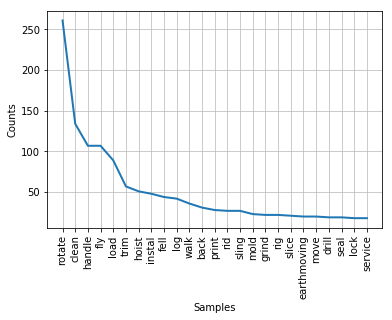

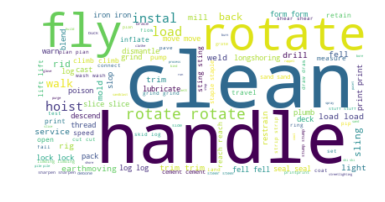

Top 3 activity word and their sentences


rotate

rotating parts hand
rotating parts work rules
rotating shaft
rotating parts
rotating parts rotating shaft
rotating shaft chain sprocket
rotating parts finger
rotating parts
rotating parts aircraft propeller laceration fracture inattention
rotating parts arm



clean
=====

cleaning pump
cleaning air
cleaning air
cleaning point
cleaning air
cleaning fall struck
cleaning conveyor
cleaning rotating parts
cleaning printing machine
cleaning hatch guard lockout



handle

handling ind trk operator
handling auger cleaning
handling motor vehicle
handling fall
handling work rules
handling work rules
handling falling object bleach chemical burn leg
handling roller
handling lockout
handling roller


Falls


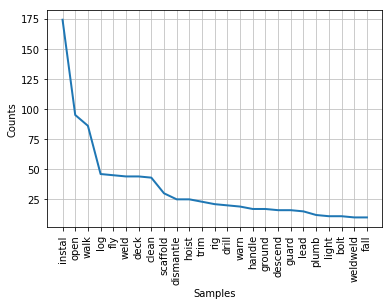

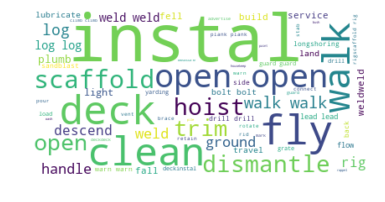

Top 3 activity word and their sentences


instal

installing ladder scaffold structure
installing arm fracture face abrasion
installing work rules
installing wrist
installing stakes
installing wall
installing skylight fall fall protection neck fracture
installing air conditioner
installing air conditioner
installing anchor roof



open
====

opening cover ladder
opening work rules
opening fall protection fall demolition construction asbestos removal work rules
opening cover fall fracture head
opening fall fall protection
opening maintenance ladder catwalk fall head fracture
opening ceiling panel fall protection
opening head
opening ceiling fall
opening shoulder elbow pelvis guardrail cover



walk
====

walking surface
walking on beam
walking surface fall fracture
walking backward construction fall fracture floor
walking surface
walking on beam rafter
walking backward inattention dismantling boat maintenance
walking on beam iron worker contusion
walking surface carpet
walking surface



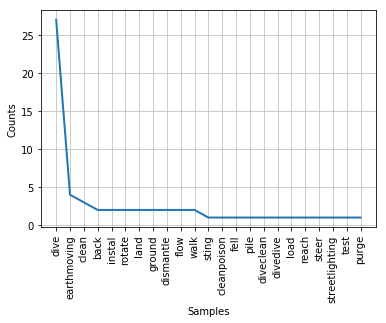

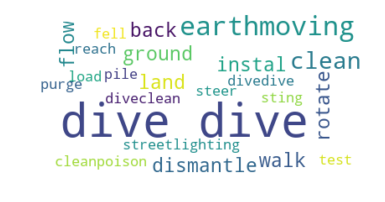

Top 3 activity word and their sentences


dive
====

diving commercial diving
diving air line respirator carbon monoxide
diving embolism inexperience air line mech malfunction air pressure
diving air hose
diving commercial diving
diving drown scuba diving water
diving unconsciousness scuba commercial diving cpr diver water
diving cpr embolism
diving mech malfunction
diving commercial diving cpr scuba boat



earthmoving

earthmoving equip bulldozer
earthmoving equip
earthmoving equip



clean
=====

cleaning poisoning skin ppe
cleaning bee
cleaning drown seizure construction water unconsciousness
cleaning seizure water drown


Other


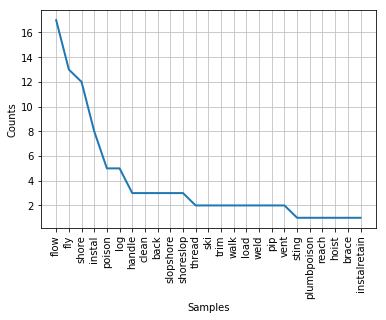

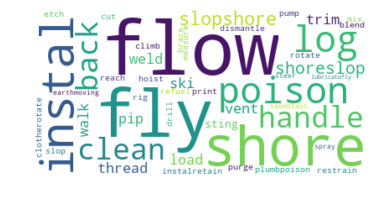

Top 3 activity word and their sentences


flow
====

flowing material
flowing material
flowing material
flowing material
flowing material winch vibrations
flowing material safety
flowing material
flowing material work rules
flowing material
flowing material



fly
===

flying object neck spine valve
flying object
flying object equipment failure
flying object chest
flying object high pressure
flying object lockout
flying object construction pressure release work rules
flying object high pressure
flying object
flying object



shore
=====

shoring excavation
shoring fall ear backhoe
shoring collapse tendon arm leg
shoring collapse
shoring unstable soil pipe
shoring unguarded construction collapse
shoring agriculture
shoring trench box
shoring sloping trench box
shoring sloping work rules


Struck By Moving Objects


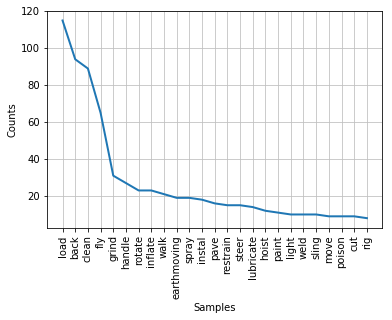

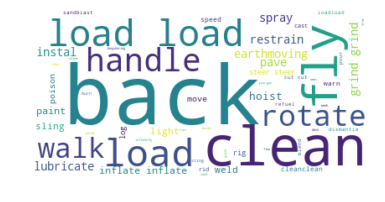

Top 3 activity word and their sentences


load
====

loading machinist abrasive wheel
loading trailer
loading agriculture heat heat exhaustion vomit alcohol
loading dock overturn
loading tractor trailer pallet loading dock run
loading asphalt burn
loading caught
loading dock trailer truck
loading dock
loading trailer backhoe



back
====

backing up brake accelerator pedal
backing up accelerator pedal
backing up back-up alarm
backing up back-up alarm
backing up back-up alarm struck
backing up back-up alarm
backing up back-up alarm struck
backing up back-up alarm
backing up leg fracture motor vehicle
backing up back-up alarm highway road



clean
=====

cleaning conveyor
cleaning lighting fixture acetone
cleaning acetone fire burn
cleaning fluid tractor trailer eye
cleaning anhydrous ammonia chemical vapor chemical inhalation work rules
cleaning tendon laceration puncture
cleaning conveyor
cleaning meat blending mach lockout machine
cleaning guard
cleaning fan fan


Collapse of object


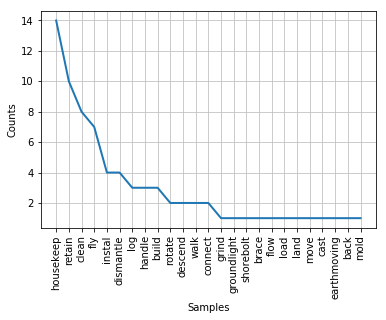

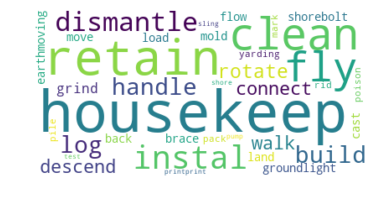

Top 3 activity word and their sentences


housekeep

housekeeping allergic reaction
housekeeping inattention communication
housekeeping fall
housekeeping vapor
housekeeping explosion contusion chest hearing loss
housekeeping fall heart attack cardiac arrest
housekeeping cleaning vacuum
housekeeping janitor cleaning
housekeeping janitor cleaning fall fracture knee slip
housekeeping amputated finger paint cleaning



retain

retaining wall
retaining wall bracing collapse
retaining wall lung
retaining wall collapse
retaining wall
retaining wall
retaining wall lawn mower
retaining wall
retaining wall collapse cleaning demolition
retaining wall underpinning



clean
=====

cleaning extension
cleaning toxic
cleaning lung ppe toxic atmosphere
cleaning unstable soil work rules
cleaning fluid collapse


Fires and Explosion


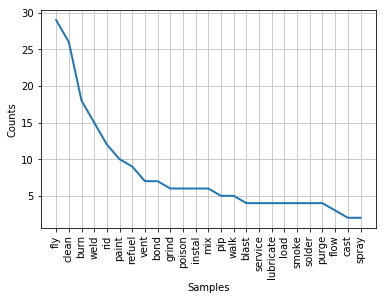

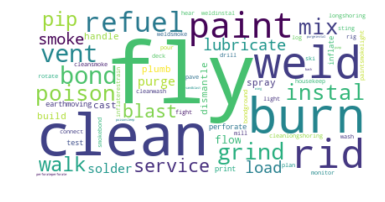

Top 3 activity word and their sentences


fly
===

flying object pipeline blowout
flying object explosion boiler gas leak contusion abrasion food preparation arm
flying object bolt stepladder explosion
flying object cylinder leg rupture
flying object
flying object boiler steam
flying object explosive mixing
flying object chemical chemical reaction contusion
flying object laceration eye face
flying object untrained contusion



clean
=====

cleaning explosion fire burn work rules cleaning fluid ventilation
cleaning hopper coal hatch burn
cleaning benzene static electricity
cleaning burn fire head mixer tank
cleaning coal tar
cleaning combustible liquid burn face arm
cleaning longshoring explosion
cleaning work rules
cleaning flammable vapors
cleaning laceration



burn
====

burning leg burn fire fire extinguisher
burning naphtha fire
burning drum
burning cylinder fire explosion
burning torch oxygen propylene
burn chemical fertilizer mixing irrigation equipment water pump explosion nitr

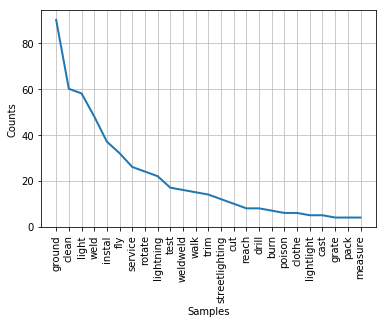

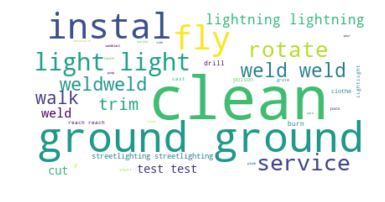

Top 3 activity word and their sentences


ground

grounding untrained e gi vii
grounding attachment plug
grounding cord
grounding conveyor
grounding electric cord attachment plug pump wet operation
grounding attachment plug
grounding elec equipment
grounding welder attachment plug e gi v
grounding electric generator
grounding cord connector attachment plug cord



clean
=====

cleaning work rules
cleaning welding fire
cleaning fluid work rules
cleaning ppe work rules
cleaning brush chipper milling machine guard
cleaning water tank
cleaning poisoning carbon monoxide ventilation gasoline
cleaning food preparation unconsciousness cardiovasc system respiratory
cleaning electric saw casting
cleaning ceiling panel work rules



light
=====

lighting fixture maintenance
lighting fixture
lighting air shaft
lighting circuit airport e gi iv
lightning amuse park/carnival
lighting ladder shock
lighting lockout electric conductor
lighting inexperience
lighting electrocuted maintenance
lighting lock

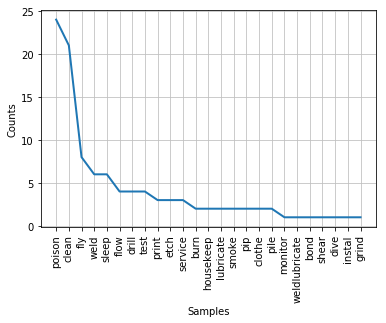

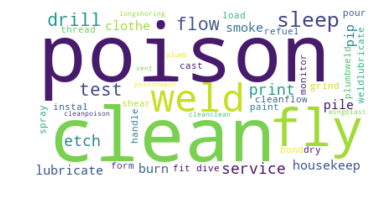

Top 3 activity word and their sentences


poison

poisoning emergency response
poisoning inhalation ventilation
poisoning chemical vapor
poisoning chlorine gas cylinder throat cough vomit eye
poisoning lawn
poisoning ventilation work rules heart
poisoning exhaust fumes
poisoning chemical vapor inhalation gas fumigant
poisoning unconsciousness gas cleaning pool gasoline ventilation
poisoning toxic fumes



clean
=====

cleaning fluid lung air contamination toxic fumes
cleaning bleach chemical reaction
cleaning fluid toxic fumes
cleaning ppe storage tank carbon disulfide
cleaning fluid drain
cleaning oxygen electric drill arm face
cleaning unconsciousness inhalation chemical vapor vapor ppe
cleaning flowing material inhalation
cleaning gas exhaust fumes
cleaning hazardous waste chemical



fly
===

flying object high pressure fire extinguisher rupture guard air pressure
flying object explosion
flying object
flying object chemical vapor
flying object gas
flying object gas leak
flying obje

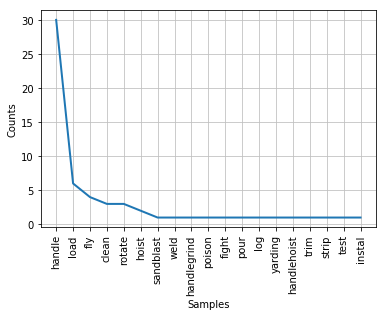

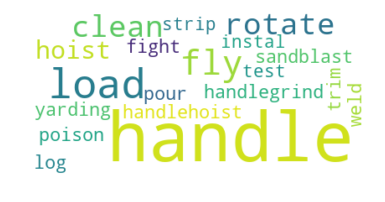

Top 3 activity word and their sentences


handle

handling leg
handling grain
handling baggage conveyor
handling alcohol
handling auger auger mechanism
handling chemical burn
handling chair sprain
handling heart
handling skin dermatitis chemical creosote
handling grinding wheel equipment failure



load
====

loading truck extension handle
loading manual mat handling corn
loading ramp
loading mech mat handling
loading manual mat handling caught
loading heart



fly
===

flying object face
flying object gasket
flying object mech mat handling face puncture barge pier construction
flying object leg fracture extension


Exposure to extreme temperatures


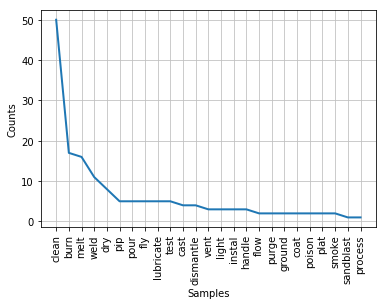

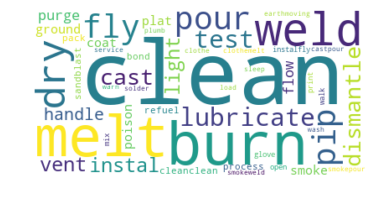

Top 3 activity word and their sentences


clean
=====

cleaning chemical burn ppe jet fuel hand
cleaning maintenance
cleaning ash high temperature
cleaning flammable vapors
cleaning work rules
cleaning carbon disulfide tank
cleaning burn
cleaning fluid
cleaning caustic degreaser chemical work rules
cleaning chemical burn foot ankle



burn
====

burning torch acetylene torch burn explosion hearing loss face neck chest arm
burning flammable vapors
burning drum isopropyl alcohol explosion torch
burning torch scrap metal baler welder
burn chemical burn pressure piping pressure release
burning torch
burning fire burn clothing
burning torch column
burning heptane
burning face



melt
====

melting furnace
melting furnace jack
melting furnace explosion
melting furnace plastic mfg
melting furnace steel molten
melting furnace explosion burn
melting furnace scrap metal steel
melting furnace water chemical work rules
melting furnace furnace chemical reaction work rules
melting furnace


Osha Ext

In [537]:
if ProcessOshaDataSet:
    chunk_count = 0
    verb_count = 0
    for cat in OshaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Osha Extraction Chunk Count is " +  str(chunk_count))
    print("Osha Extraction Verb Count is " +  str(verb_count))       

# Notes and Observation: 
- For the Msia dataset which is used as training dataset, the summary columns are mostly made up of complete grammatically sound sentences and thus the regular expression parser method is chosen to extract the activity phrases.

- However, for the Osha dataset, not all sentences are complete and grammatically sound like the Msia dataset. Some of the activities descripton in the summary column are made up of just keywords instead of complete sentences thus that could result in these rows data being omitted when perform the regular expression parsing. Thus only about 5000 of the 16000 rows in which activity can be found using the parser developed in Msia dataset.

- Further improvements: Need to tweak the reg parser to cater for the "keywords" style description in the OSHA dataset. Some of the activities captured are actually describing the cause of the incident, thus in order to get a more accurate text mining on activities, prior domain knowledge on what is considered cause and what is activities need to be incorporated.